<a href="https://colab.research.google.com/github/Arman001/marketing-with-ml/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation with Machine Learning**
***
### **By:** Muhammad Saad
***


## Import Libraries

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.animation as animation
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML


## Load the dataset


In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
dataset = pd.read_excel(url)

In [4]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Preprocessing

### Data Cleaning

In [5]:
# Remove rows with missing CustomerID (since we need customer-level data)
dataset.dropna(subset=['CustomerID'], inplace=True)

# Remove rows with negative or zero quantities (likely returns or errors)
dataset = dataset[dataset['Quantity'] > 0]


In [6]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Feature Engineering

In [7]:
# Convert InvoiceDate to datetime format
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])

# Calculate TotalPrice = Quantity * UnitPrice (total money spent per transaction)
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']

<ipython-input-7-d5727822ce6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])
<ipython-input-7-d5727822ce6a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']


In [8]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [9]:
# RFM Analysis (Recency, Frequency, Monetary)
current_date = dataset['InvoiceDate'].max()  # Assume this as the "current date"
rfm = dataset.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency: days since last purchase
    'InvoiceNo': 'nunique',  # Frequency: number of unique invoices (transactions)
    'TotalPrice': 'sum'  # Monetary: total money spent
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Handle Outliers (optional but recommended)
# Remove rows with extremely high Monetary values (outliers can skew clustering)
rfm = rfm[rfm['Monetary'] > 0]  # Only consider customers who have made purchases
upper_limit = np.percentile(rfm['Monetary'], 99)
rfm = rfm[rfm['Monetary'] <= upper_limit]

In [10]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
5,12352.0,35,8,2506.04


### Feature Scaling

In [11]:
# Normalize the RFM features before clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [12]:
rfm_scaled

array([[-0.91163737,  0.63916062,  1.37473762],
       [-0.18217202,  0.02685549,  0.18306109],
       [-0.74176188, -0.58544964,  0.16423811],
       ...,
       [-0.85168131, -0.38134793, -0.58483983],
       [-0.89165202,  2.476076  ,  0.32421687],
       [-0.50193765, -0.17724622,  0.20205006]])

## KMeans Training


## Elbow Method

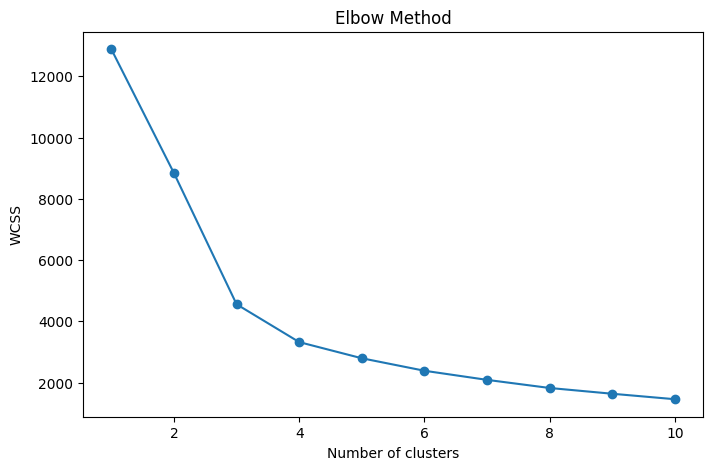

In [13]:
# Calculate WCSS for different number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Training

In [14]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

## Visualizing the Clusters

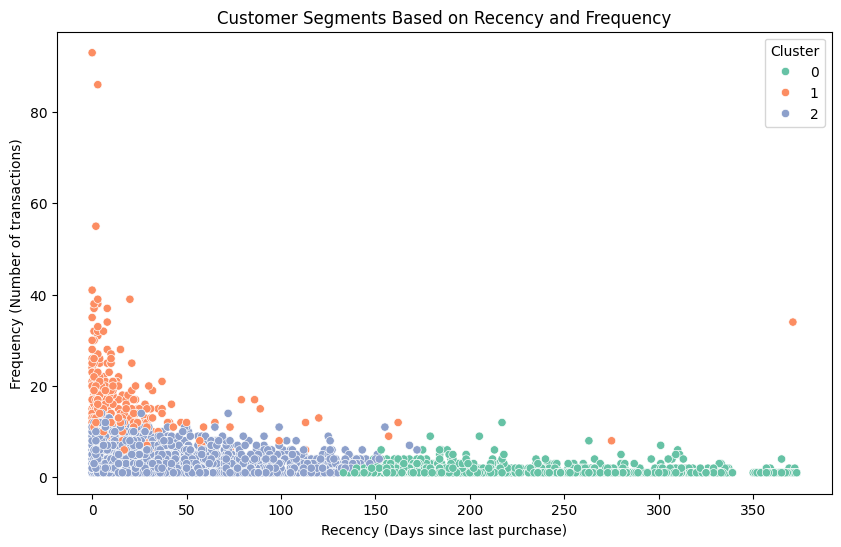

In [15]:
# Visualize the segments by plotting Recency vs Frequency and coloring by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Frequency'], hue=rfm['Cluster'], palette='Set2')
plt.title('Customer Segments Based on Recency and Frequency')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Frequency (Number of transactions)')
plt.show()

## Analyze Customer Segments

In [16]:
# Analyze each cluster's characteristics by averaging Recency, Frequency, and Monetary values
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max']
}).reset_index()

# Print the cluster analysis to see the characteristics of each segment
print(cluster_analysis)

  Cluster     Recency            Frequency             Monetary           \
                 mean  min  max       mean min max         mean      min   
0       0  245.919070  133  373   1.514419   1  12   440.965080     3.75   
1       1   18.475728    0  371  16.459547   2  93  7214.543689  1296.44   
2       2   43.287285    0  172   3.401031   1  14  1153.446004     6.20   

             
        max  
0   4959.10  
1  19824.05  
2   6748.80  


## Animating KMeans

In [17]:
# # Prepare the figure for animation
# fig, ax = plt.subplots(figsize=(8, 5))
# ax.set_title('K-Means Clustering Animation')
# ax.set_xlabel('Recency (Days since last purchase)')
# ax.set_ylabel('Monetary (Total Spending)')

# # Initial plot of grey points (not used in animation)
# scatter = ax.scatter(rfm['Recency'], rfm['Monetary'], c='lightgray', marker='o')

# # Animation update function
# def update(frame):
#     ax.clear()  # Clear the axes for a fresh plot
#     ax.set_title('K-Means Clustering Animation')
#     ax.set_xlabel('Recency (Days since last purchase)')
#     ax.set_ylabel('Monetary (Total Spending)')

#     # K-Means initialization and fitting
#     kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=1, random_state=frame)
#     kmeans.fit(rfm_scaled)

#     # Plot points with cluster colors based on labels from KMeans
#     scatter = ax.scatter(rfm['Recency'], rfm['Monetary'], c=kmeans.labels_, cmap='viridis', marker='o')

#     # Plot cluster centers in red 'X'
#     centers = scaler.inverse_transform(kmeans.cluster_centers_)
#     ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centers')
#     ax.legend()

# # Create animation and display it in Colab
# ani = animation.FuncAnimation(fig, update, frames=30, repeat=False, interval=1000)
# HTML(ani.to_jshtml())